# Example of EMM for machine learning reweighting using ADMM optimisation

Using the PIMA diabetes dataset we compare the original dataset with labels to the reweighted dataset with artificial labels. We begin by importing the PIMA diabetes dataset, it is already cleaned and does not have any missing values, outliers, etc. This example is also nice since all features are continuous and the labels are binary.

In [5]:
# Get raw data, convert to csv, and import
# Update directory
import sys
sys.path.insert(1, '../')
# Import libraries
from emm import *
import os.path
from get_data import get_data
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np

# Data locations
raw_dir = "../assets/data/raw/pima_diabetes/archive.zip"
processed_dir = "../assets/data/processed/pima_diabetes/"

# If processed data does exist convert raw to csv
if not os.path.exists(processed_dir + "diabetes.csv"):
    get_data.unzip(raw_dir,processed_dir)
    
# Get data into dataframe
df = pd.read_csv(processed_dir + "diabetes.csv",index_col=0)

# Replace 0 with nan
nan_cols = ['Glucose', 'BloodPressure','SkinThickness','Insulin','BMI']
df[nan_cols]=df[nan_cols].replace({'0':np.nan,0:np.nan})

(array([173., 127.,  96.,  61.,  41.,  51.,  47.,  39.,  34.,  18.,  21.,
         13.,  15.,  11.,   8.,   8.,   3.,   1.,   0.,   1.]),
 array([21., 24., 27., 30., 33., 36., 39., 42., 45., 48., 51., 54., 57.,
        60., 63., 66., 69., 72., 75., 78., 81.]),
 <BarContainer object of 20 artists>)

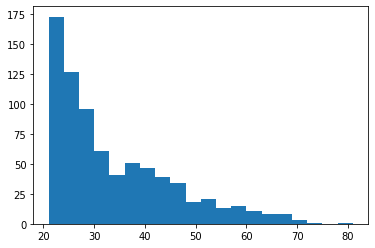

In [59]:
plt.hist(df['Age'],bins=20)

Separating features from labels, useful for training ML models and for re-weighting.

In [6]:
#train_test_splitting of the dataset
X = df.drop(columns = 'Outcome')
# Getting Predicting Value
y = df['Outcome']

First, we look at the means for each features according to outcome.

In [7]:
marginals_mean = df.groupby('Outcome').mean()
display(marginals_mean)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
Outcome,,,,,,,,
0,3.298000,110.643863,70.877339,27.235457,130.287879,30.859674,0.429734,31.190000
1,4.865672,142.319549,75.321429,33.000000,206.846154,35.406767,0.550500,37.067164


We may also want to consider standard deviation of features.

### Matching marginals

First we construct functions $F$ upon which we take expectations of under the weighted measure. Mathematically, we express this as
$$ \mathbb E[F(x)] = \sum^N_{i=1} w_i F(x_i) $$

In [50]:
features = ["Insulin"]
marginals = {}
for feature in features:
    marginals[feature] = ["mean", "std"]
marginals

{'Insulin': ['mean', 'std']}

In [ ]:
{'Glucose' : {'marginal': ['mean', 'std'], 'loss' : [LeastSquaresLoss(mu), LeastSquaresLoss(sig)]}}

Create loss tables, using least squared loss and 

In [51]:
f = lambda x : x

In [52]:
loss_0 = []
loss_1 = []
for feature in marginals.keys():
    for fun in marginals[feature]:
        marg = getattr(df[[feature,'Outcome']].groupby('Outcome'),fun)()
        loss_0.append(EqualityLoss(marg.loc[0]))
        loss_1.append(EqualityLoss(marg.loc[1]))

In [53]:
#regularizer = regularizers.EntropyRegularizer(limit=None)
regularizer = regularizers.ZeroRegularizer()
w_0, out_0 = emm(X, marginals, loss_0, regularizer=regularizer, optimizer='admm')
w_1, out_1 = emm(X, marginals, loss_1, regularizer, optimizer='admm')

In [54]:
X_0 = X.copy()
X_0["weights"] = w_0 
X_1 = X.copy()
X_1["weights"] = w_1 

# Set theoretical outcome to train on reweighted datasets
X_0['Outcome'] = 0
X_1['Outcome'] = 1

df_w = pd.concat([X_0,X_1])

In [55]:
df_valw = df_w.drop(columns=['Outcome','weights']).multiply(df_w['weights'], axis="index")
df_valw['Outcome'] = df_w['Outcome']

In [56]:
w_marginals = df_valw.groupby('Outcome').sum()

In [57]:
display(marginals_mean)
display(w_marginals)
display(abs((marginals_mean - w_marginals)))

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
Outcome,,,,,,,,
0,3.298000,110.643863,70.877339,27.235457,130.287879,30.859674,0.429734,31.190000
1,4.865672,142.319549,75.321429,33.000000,206.846154,35.406767,0.550500,37.067164


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
Outcome,,,,,,,,
0,3.789113,116.797056,68.527211,18.909082,57.815973,31.437681,0.458393,32.976701
1,3.909429,122.648121,68.924834,19.405053,90.855484,31.969552,0.470035,33.760606


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
Outcome,,,,,,,,
0,0.491113,6.153192,2.350128,8.326375,72.471906,0.578006,0.028659,1.786701
1,0.956243,19.671428,6.396595,13.594947,115.990670,3.437215,0.080465,3.306558


In [31]:
std_w = pd.concat([abs(X_0[features] - marginals_mean.loc[0]),abs(X_1[features] - marginals_mean.loc[1])])
std_w = std_w.multiply(df_w['weights'], axis="index")
std_w = pd.concat([std_w, df_w['Outcome']],axis=1)

In [32]:
display(marginals_std)
display(std_w.groupby('Outcome').sum())
display(abs((marginals_std - std_w.groupby('Outcome').sum())))

NameError: name 'marginals_std' is not defined